<span style="font-size:22px;font-family:Dubai;"> Import libraries </span>

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams["figure.dpi"] = 80

<span style="font-size:22px;font-family:Dubai;"> Import data </span>

In [2]:
data = pd.read_csv("adult.csv", header=None, names=["age","workclass","final_weight","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","income"])

In [3]:
data.head()

,age,workclass,final_weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<span style="font-size:22px;font-family:Dubai;"> What is the dimension of data? </span>

In [4]:
def row_col(data):
    print("Total rows present in dataset    - {}".format(data.shape[0]))
    print("Total columns present in dataset - {}".format(data.shape[1]))

print("Training Data:")
row_col(data)

Training Data:
Total rows present in dataset    - 32561
Total columns present in dataset - 15


<span style="font-size:22px;font-family:Dubai;"> Let's find categorical features and numerical features </span>

In [5]:
def get_cat_num(data):
    
    categorical = []
    numerical = []

    for column in data.drop("income", axis=1).columns:
        if data[column].dtype == "O":
            categorical.append(column)
        else:
            numerical.append(column)
    return categorical, numerical

categorical, numerical = get_cat_num(data)
print("There are {} categorical features.".format(len(categorical)))
print("Categorical features: {}".format(categorical))
print()
print("There are {} numerical features.".format(len(numerical)))
print("Numerical features: {}".format(numerical))

There are 8 categorical features.
Categorical features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

There are 6 numerical features.
Numerical features: ['age', 'final_weight', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [6]:
def strip_data(data):
    for cat_f in categorical:
        data[cat_f] = data[cat_f].str.strip()
        
strip_data(data)

<span style="font-size:22px;font-family:Dubai;"> Is there any duplicated rows? </span>

In [9]:
if data.duplicated().sum():
    print("Yes! There are", data.duplicated().sum(), "duplicate rows.")
    data.drop_duplicates(inplace=True)

Yes! There are 24 duplicate rows.


In [10]:
for cat in categorical:
    print(cat + ":")
    print(data[cat].unique())
    print("--------------------------------------------------------------------------------")

workclass:
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
--------------------------------------------------------------------------------
education:
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
--------------------------------------------------------------------------------
marital-status:
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
--------------------------------------------------------------------------------
occupation:
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
------------------------------------------------------------

In [11]:
data = data.replace('?','Unknown')

<span style="font-size:22px;font-family:Dubai;"> Analysis of Categorical Data </span>

In [17]:
summary = pd.DataFrame(columns=["Feature", "Relationship", "Strength"])

def get_plot(feature, rot=0):
    crossTable = pd.crosstab(data[feature],data["income"])
    percTable = crossTable.div(crossTable.sum(axis=0), axis=1)*100
    ax = percTable.plot(kind="bar", figsize=(15,5), title="Income of Adult - "+feature, rot=rot)
    ax.set_ylabel("Percentage", fontsize=10)
    ax.set_xlabel(feature, fontsize=12)
    plt.show()

def cramers_v_test(feature):
    global summary
    crossTable = pd.crosstab(data[feature],data["income"])
    chiVal, pVal, df, exp = stats.chi2_contingency(crossTable)
    print("Chi-square value :", round(chiVal,4))
    print("P Value          :", pVal)
    print()
    
    if pVal < 0.05:
        r = len(crossTable.index)
        c = len(crossTable.columns)
        n = crossTable.to_numpy().sum()
        v = np.sqrt(chiVal / (n * (min(r,c)-1)))

        print("Income is dependent on", feature, end=". ")
        print("Cramér’s V: ", round(v,2))

        if df == 1:
            if v < 0.10:
                relationship = "Negligible"
                print("Relationship: negligible")
            elif v < 0.30:
                print("Relationship: small")
            elif v < 0.50:
                print("Relationship: medium")
            else:
                print("Relationship: large")

        elif df == 2:
            if v < 0.07:
                relationship = "Negligible"
                print("Relationship: negligible")
            elif v < 0.21:
                relationship = "Small"
                print("Relationship: small")
            elif v < 0.35:
                relationship = "Medium"
                print("Relationship: medium")
            else:
                relationship = "Large"
                print("Relationship: large")

        elif df == 3:
            if v < 0.06:
                relationship = "Negligible"
                print("Relationship: negligible")
            elif v < 0.17:
                relationship = "Small"
                print("Relationship: small")
            elif v < 0.29:
                relationship = "Medium"
                print("Relationship: medium")
            else:
                relationship = "Large"
                print("Relationship: large")

        elif df == 4:
            if v < 0.05:
                relationship = "Negligible"
                print("Relationship: negligible")
            elif v < 0.15:
                relationship = "Small"
                print("Relationship: small")
            elif v < 0.25:
                relationship = "Medium"
                print("Relationship: medium")
            else:
                relationship = "Large"
                print("Relationship: large")

        else:
            if v < 0.05:
                relationship = "Negligible"
                print("Relationship: negligible")
            elif v < 0.13:
                relationship = "Small"
                print("Relationship: small")
            elif v < 0.22:
                relationship = "Medium"
                print("Relationship: medium")
            else:
                relationship = "Large"
                print("Relationship: large")
                
        summary = summary.append({"Feature":feature, "Relationship":relationship, "Strength":round(v,2)}, ignore_index=True)
    else:
        print("Income is not dependent on",feature)

<span style="font-size:22px;font-family:Dubai;"> Workclass </span>

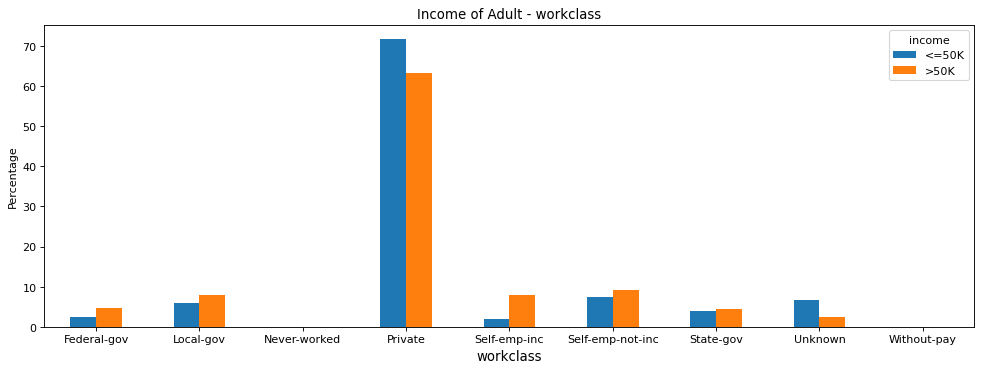

In [15]:
get_plot("workclass")

In [18]:
cramers_v_test("workclass")

Chi-square value : 1044.6962
P Value          : 3.352256069028484e-220

Income is dependent on workclass. Cramér’s V:  0.18
Relationship: medium


<span style="font-size:22px;font-family:Dubai;"> Education </span>

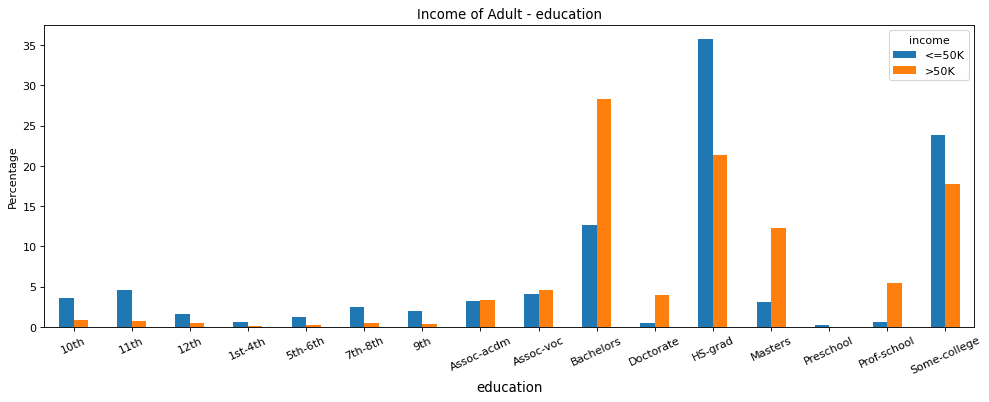

In [19]:
get_plot("education", 25)

In [22]:
data["education"] = np.where(data["education"].isin(["Preschool","1st-4th","5th-6th","7th-8th","9th","10th","11th","12th"]), "School", data["education"])
data['education'] = data['education'].map({'School':0,'HS-grad':1,'Some-college':2,'Assoc-voc':3,'Assoc-acdm':4,'Bachelors':5,'Masters':6,'Prof-school':7,'Doctorate':8})

In [23]:
cramers_v_test("education")

Chi-square value : 4425.2842
P Value          : 0.0

Income is dependent on education. Cramér’s V:  0.37
Relationship: large


<span style="font-size:22px;font-family:Dubai;"> Marital-status </span>

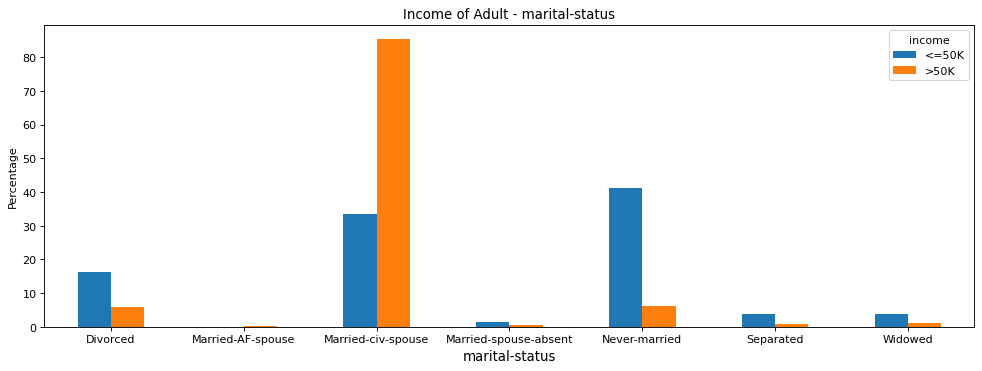

In [24]:
get_plot("marital-status")

In [25]:
cramers_v_test("marital-status")

Chi-square value : 6510.3321
P Value          : 0.0

Income is dependent on marital-status. Cramér’s V:  0.45
Relationship: large


<span style="font-size:22px;font-family:Dubai;"> Occupation </span>

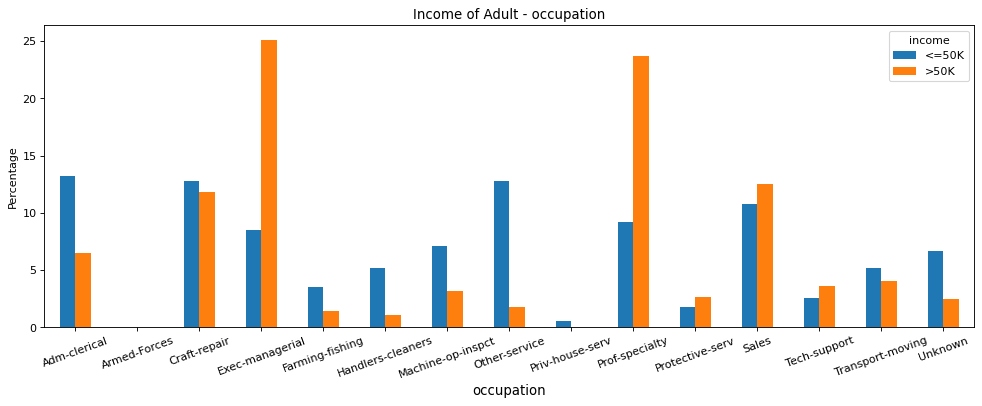

In [26]:
get_plot("occupation", 20)

In [27]:
cramers_v_test("occupation")

Chi-square value : 4030.2092
P Value          : 0.0

Income is dependent on occupation. Cramér’s V:  0.35
Relationship: large


<span style="font-size:22px;font-family:Dubai;"> Relationship </span>

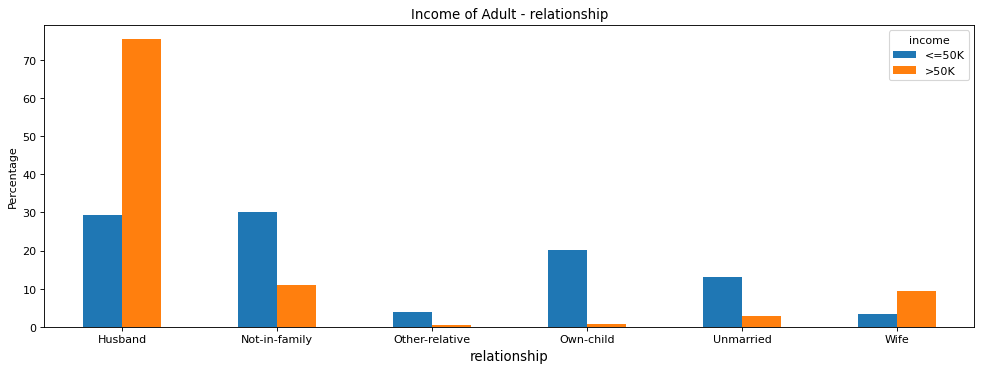

In [28]:
get_plot("relationship")

In [29]:
cramers_v_test("relationship")

Chi-square value : 6692.0988
P Value          : 0.0

Income is dependent on relationship. Cramér’s V:  0.45
Relationship: large


<span style="font-size:22px;font-family:Dubai;"> Race </span>

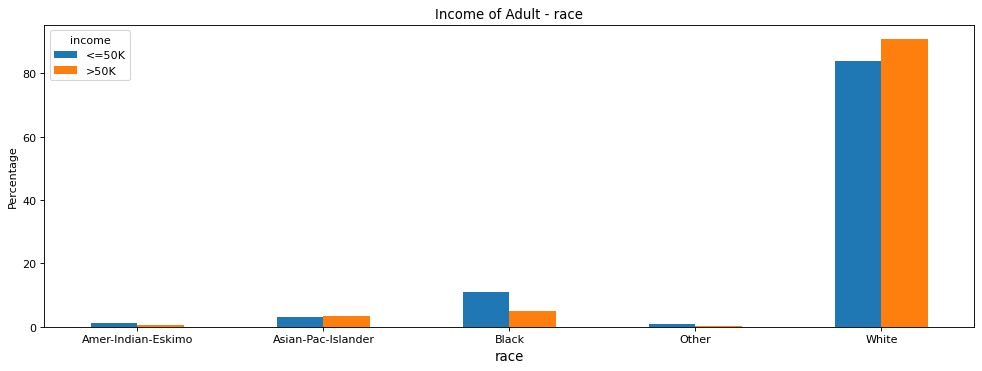

In [30]:
get_plot("race")

In [31]:
cramers_v_test("race")

Chi-square value : 330.9434
P Value          : 2.2797874171824478e-70

Income is dependent on race. Cramér’s V:  0.1
Relationship: small


<span style="font-size:22px;font-family:Dubai;"> Native-country </span>

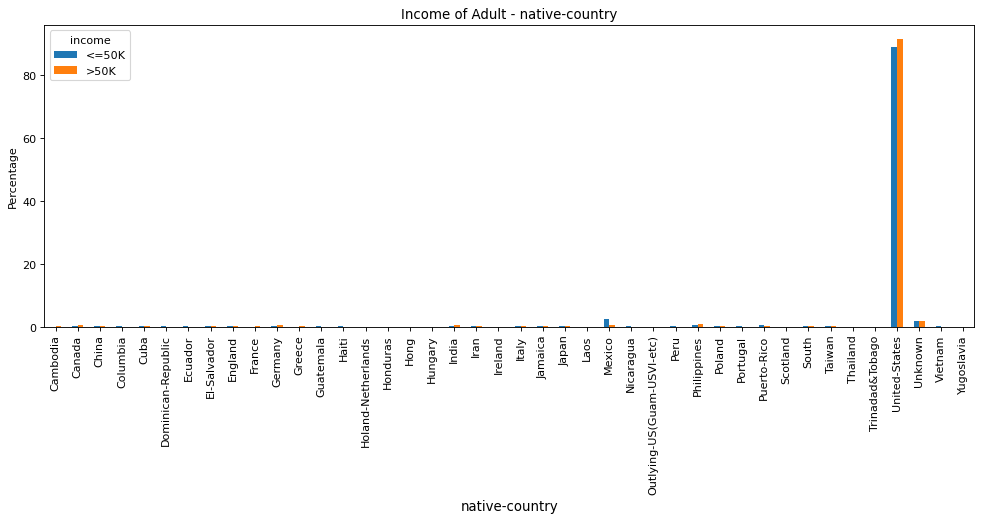

In [32]:
get_plot("native-country", 90)

In [33]:
cramers_v_test("native-country")

Chi-square value : 315.4485
P Value          : 4.833085519399296e-44

Income is dependent on native-country. Cramér’s V:  0.1
Relationship: small


In [34]:
summary

,Feature,Relationship,Strength
0,workclass,Medium,0.18
1,education,Large,0.37
2,marital-status,Large,0.45
3,occupation,Large,0.35
4,relationship,Large,0.45
5,race,Small,0.10
6,native-country,Small,0.10


Okay! You can clearly see <b>race</b> and <b>native-country</b> both can be dropped as they have small relationship with dependent variable.

In [35]:
data.drop(["race", "native-country"], axis=1, inplace=True)

<span style="font-size:24px;font-family:Dubai;"> Analysis of Numerical Data </span>

<span style="font-size:22px;font-family:Dubai;"> Age </span>

[]

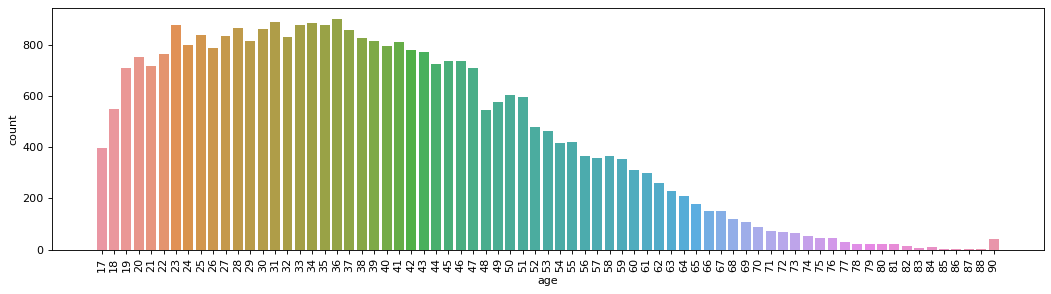

In [36]:
plt.figure(figsize=(16,4))
sns.countplot(data["age"])
plt.xticks(rotation=90)
plt.plot()

<span style="font-size:22px;font-family:Dubai;"> Education-num </span>

In [38]:
data['education-num'].unique()

array([13,  9,  7, 14,  5, 10, 12, 11,  4, 16, 15,  3,  6,  2,  1,  8],
      dtype=int64)

Seems like <b>education</b> and <b>education-num</b> are same features. education-num is just numerical representation of education. So, <b>We'll drop education-num</b>.

In [39]:
data.drop("education-num", axis=1, inplace=True)

<span style="font-size:22px;font-family:Dubai;"> Final Weight </span>

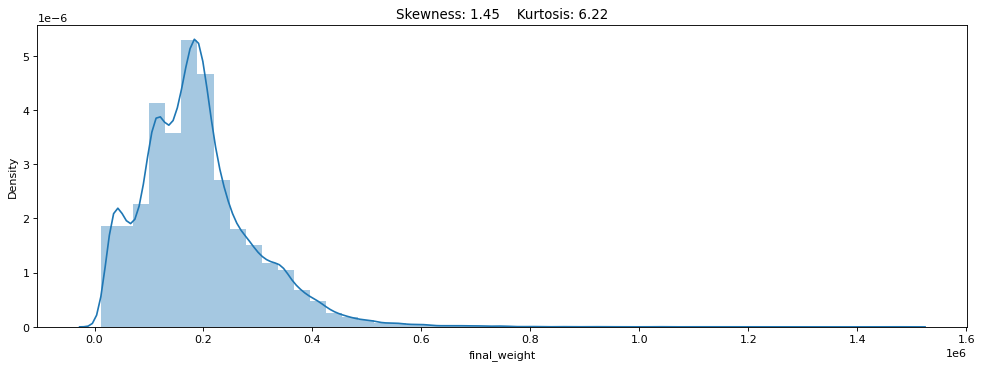

In [40]:
plt.figure(figsize=(15,5))
sns.distplot(data['final_weight'])
plt.title("Skewness: "+ str(round(data['final_weight'].skew(),2)) + "    " + "Kurtosis: " + str(round(data['final_weight'].kurtosis(),2)))
plt.show()

<b>Final weight</b> is right skewed. We need to make it normal for further tasks.

In [41]:
data['final_weight'] = np.log1p(data[['final_weight']])

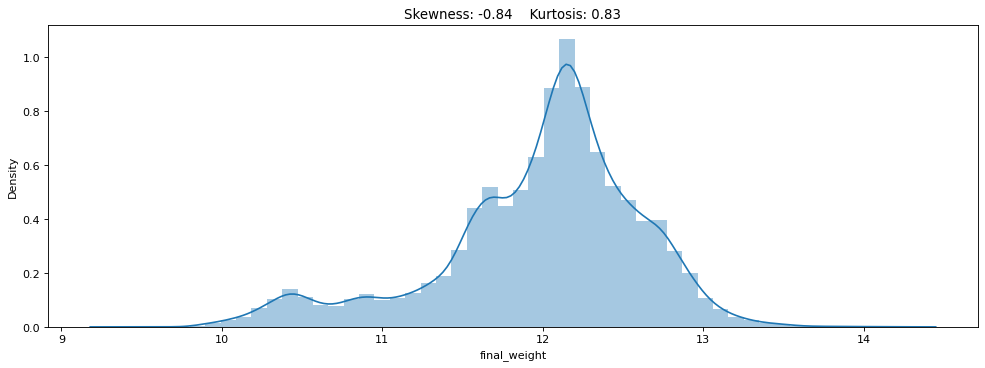

In [42]:
plt.figure(figsize=(15,5))
sns.distplot(data['final_weight'])
plt.title("Skewness: "+ str(round(data['final_weight'].skew(),2)) + "    " + "Kurtosis: " + str(round(data['final_weight'].kurtosis(),2)))
plt.show()

<span style="font-size:22px;font-family:Dubai;"> Capital Gain </span>

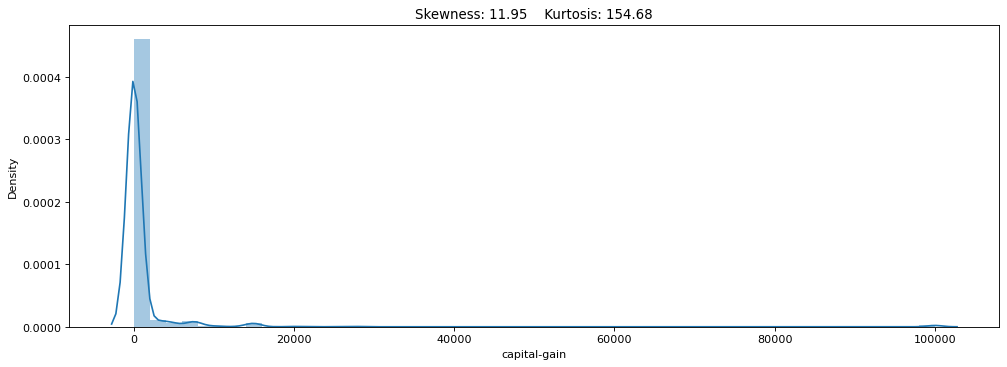

In [43]:
plt.figure(figsize=(15,5))
sns.distplot(data['capital-gain'])
plt.title("Skewness: "+ str(round(data['capital-gain'].skew(),2)) + "    " + "Kurtosis: " + str(round(data['capital-gain'].kurtosis(),2)))
plt.show()

Again, <b>capital gain</b> is right skewed.

<AxesSubplot:xlabel='income', ylabel='capital-gain'>

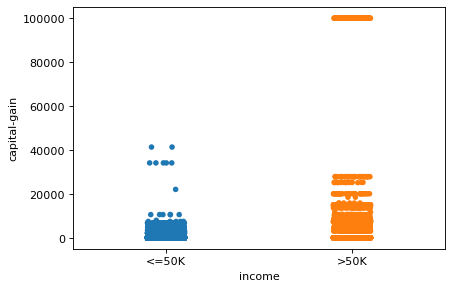

In [44]:
sns.stripplot(data=data, x='income', y='capital-gain')

In [45]:
data["capital-gain"] = np.where(data["capital-gain"]>=7000, 1, 0)

<span style="font-size:22px;font-family:Dubai;"> Capital Loss </span>

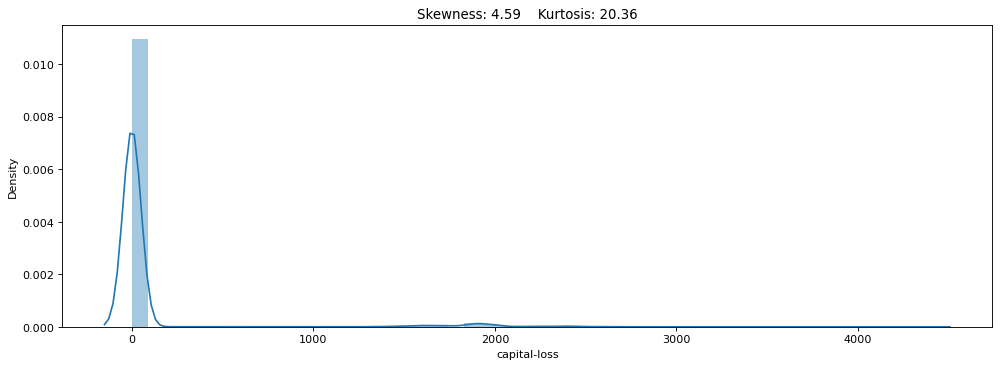

In [46]:
plt.figure(figsize=(15,5))
sns.distplot(data['capital-loss'])
plt.title("Skewness: "+ str(round(data['capital-loss'].skew(),2)) + "    " + "Kurtosis: " + str(round(data['capital-loss'].kurtosis(),2)))
plt.show()

In [47]:
data["capital-loss"] = data["capital-loss"].apply(lambda x: x ** (1/2))

<span style="font-size:22px;font-family:Dubai;"> Hours-per-week </span>

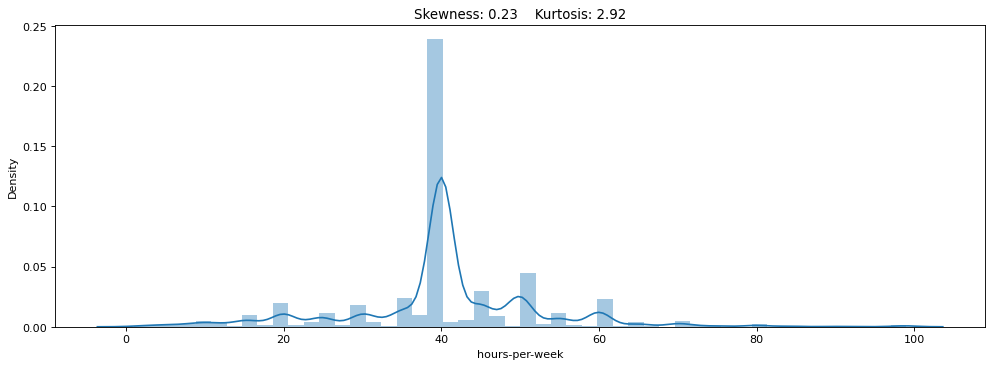

In [48]:
plt.figure(figsize=(15,5))
sns.distplot(data['hours-per-week'])
plt.title("Skewness: "+ str(round(data['hours-per-week'].skew(),2)) + "    " + "Kurtosis: " + str(round(data['hours-per-week'].kurtosis(),2)))
plt.show()

In [49]:
data['hours-per-week'] = np.where(data['hours-per-week']<35, 0, np.where(data['hours-per-week']<50, 1, np.where(data['hours-per-week']<72, 2, 3)))

In [50]:
data['income'] = data['income'].map({"<=50K":0, ">50K":1})

[]

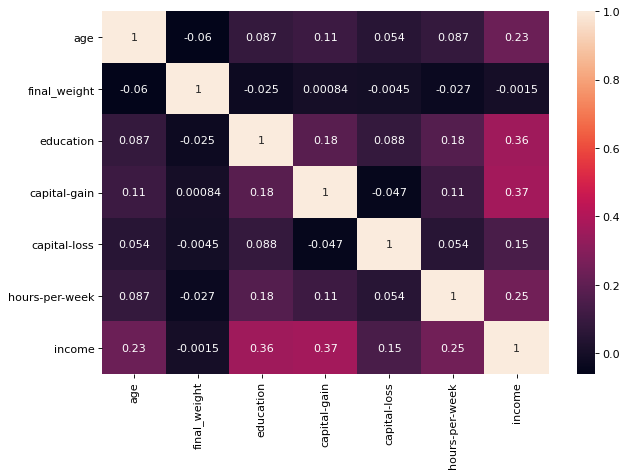

In [51]:
plt.figure(figsize=(9,6))
sns.heatmap(data.corr(), annot=True)
plt.plot()

Here, we can see that <b>final_weight</b> is not correlated with dependent variable. So, we can drop it.

In [52]:
data.drop("final_weight", axis=1, inplace=True)

In [53]:
data.head()

,age,workclass,education,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,income
0,39,State-gov,5,Never-married,Adm-clerical,Not-in-family,Male,0,0.0,1,0
1,50,Self-emp-not-inc,5,Married-civ-spouse,Exec-managerial,Husband,Male,0,0.0,0,0
2,38,Private,1,Divorced,Handlers-cleaners,Not-in-family,Male,0,0.0,1,0
3,53,Private,0,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0.0,1,0
4,28,Private,5,Married-civ-spouse,Prof-specialty,Wife,Female,0,0.0,1,0


In [54]:
X = data.drop('income', axis=1)
y = data['income']

In [55]:
# convert categorical data into numerical data
X = pd.get_dummies(X, drop_first=True)

In [56]:
X.head()

,age,education,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_Unknown,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,sex_Male
0,39,5,0,0.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,50,5,0,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,38,1,0,0.0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
3,53,0,0,0.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,28,5,0,0.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


<span style="font-size:22px;font-family:Dubai;"> Handling Imbalanced Dataset </span>

<AxesSubplot:>

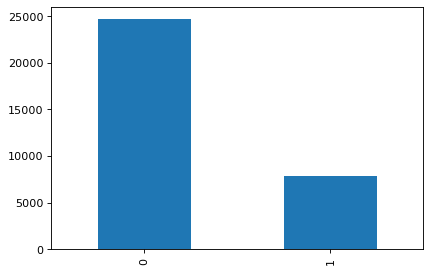

In [57]:
y.value_counts().plot(kind="bar")

In [58]:
rs = RandomOverSampler(random_state=30)
X_new, y_new = rs.fit_resample(X, y)

<AxesSubplot:>

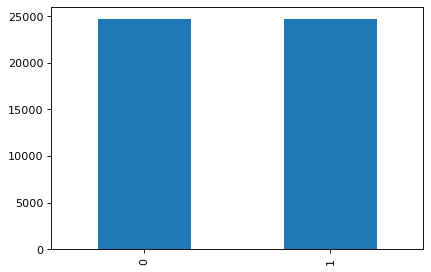

In [59]:
y_new.value_counts().plot(kind="bar")

<span style="font-size:22px;font-family:Dubai;"> Splitting data into training and testing data </span>

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=30)

In [61]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34577, 39)
X_test shape: (14819, 39)
y_train shape: (34577,)
y_test shape: (14819,)


<span style="font-size:22px;font-family:Dubai;"> Selection of Model</span>

In [62]:
models = {"LogisticRegression" : LogisticRegression(), "GaussianNB" : GaussianNB(), "RandomForestClassifier" : RandomForestClassifier(), "DecisionTreeClassifier" : DecisionTreeClassifier(), "SVC" : SVC(), "XGBClassifier" : XGBClassifier()}
scores = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    accuracy_train = round(accuracy_score(y_train, pred_train)*100, 2)
    accuracy_test = round(accuracy_score(y_test, pred_test)*100, 2)
    scores.append({'Model':model_name, 'Train accuracy':accuracy_train, 'Test accuracy':accuracy_test})

[09:47:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [63]:
df = pd.DataFrame(scores, columns=['Model', 'Train accuracy', 'Test accuracy'])
df

,Model,Train accuracy,Test accuracy
0,LogisticRegression,82.19,82.14
1,GaussianNB,74.84,75.01
2,RandomForestClassifier,95.40,88.90
3,DecisionTreeClassifier,95.40,87.35
4,SVC,81.08,81.43
5,XGBClassifier,87.43,85.74


<span style="font-size:22px;font-family:Dubai;"> Hyper-parameter Tuning</span>

In [64]:
param_grid = {
    'n_estimators': [130, 135, 140], 
    'max_depth': [30, 35, 40]
}

clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(X_train, y_train)

print("Best Score      :", 100*round(clf.best_score_, 2))
print()
print("Best Parameters :", clf.best_params_)

Best Score      : 89.0

Best Parameters : {'max_depth': 35, 'n_estimators': 135}


<span style="font-size:22px;font-family:Dubai;"> Final Model</span>

In [65]:
final_model = RandomForestClassifier(max_depth=35, n_estimators=130, random_state=30)
final_model.fit(X_train,y_train)

prediction_train = final_model.predict(X_train)
prediction_test = final_model.predict(X_test)
probs = final_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, probs)

print("Train Accuracy :", round(accuracy_score(y_train, prediction_train), 4))
print("Test Accuracy  :", round(accuracy_score(y_test, prediction_test), 4))
print("ROU AUC Score  :", round(roc_auc, 4))
print()
print("Classification Report:\n")
print(classification_report(y_test, prediction_test))

Train Accuracy : 0.9538
Test Accuracy  : 0.8891
ROU AUC Score  : 0.9513

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      7519
           1       0.85      0.93      0.89      7300

    accuracy                           0.89     14819
   macro avg       0.89      0.89      0.89     14819
weighted avg       0.89      0.89      0.89     14819



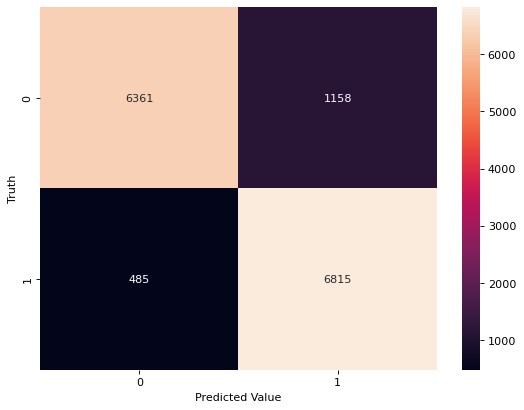

In [66]:
cm = confusion_matrix(y_test, prediction_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Value")
plt.ylabel("Truth")
plt.show()

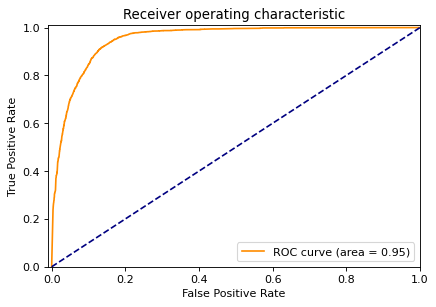

In [67]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [68]:
pickle.dump(final_model, open('final_model', 'wb'))